# Time Series Analysis of `Apple, Inc.` stock values

Time series analysis refers to the analysis of change in the trend of the data over a period of time. Time series analysis has a variety of applications. One such application is the prediction of the future price of an item based on item's past price.  
We will demonstrate time series analysis with the help of an LSTM network. We will be predicting the future stock prices of the Apple Company (AAPL), based on its stock prices of the past 9 years.

For various manipulations we will need Numpy and will plot the results using matplotlib

In [1]:
import numpy as np  
import matplotlib.pyplot as plt  
import pandas as pd  
import os

I am just curious whether my GPU card is still visible, so let me do the following.

In [2]:
import tensorflow as tf
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 18336344808268645705
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 18115349221182186641
physical_device_desc: "device: XLA_CPU device"
]


As a data set we will fetch a long string of Apple stock values at Yahoo Finance. Please go to https://finance.yahoo.com/quote/AAPL/history?p=AAPL&.tsrc=fin-srch . 
We could adjust the start date and the end data of the report and then download the dataset. For training data we selected the period between January 2nd 2012 to July 31st, 2020. Downloaded data is stored in file AAPL.csv
Too test predictive power of LSTM, we will use the Apple stock prices for the month of Augist 2020. 
To evaluate the performance of the network, as the test data, download the actual stock prices for the month of August, 2020 between August 1st and August 28th, 2020.  

Downloaded data are loaded in a panda. Besides the date index, downloaded data have 6 features: Open,	High,	Low,	Close,	Adj Close, and	Volume.
    At the moment, we do not care about all of those features. We will look only at the opening price (column Open) and ignore the others.

In [3]:
apple_training_complete = pd.read_csv('./AAPL.csv')  

<AxesSubplot:xlabel='Date'>

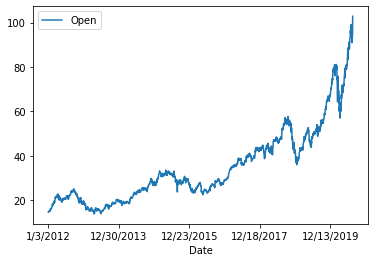

In [4]:
apple_training_complete.plot(x='Date',y='Open')

In [5]:
apple_training_complete.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
2154,7/27/2020,93.709999,94.904999,93.480003,94.809998,94.639359,121214000
2155,7/28/2020,94.367500,94.550003,93.247498,93.252502,93.084671,103625600
2156,7/29/2020,93.750000,95.230003,93.712502,95.040001,94.868950,90329200
2157,7/30/2020,94.187500,96.297501,93.767502,96.190002,96.016884,158130000
2158,7/31/2020,102.885002,106.415001,100.824997,106.260002,106.068756,374336800


In [9]:
# The following selects only data in column `Open`
apple_training_processed = apple_training_complete.iloc[:, 1:2].values  

In [10]:
print(type(apple_training_processed))

<class 'numpy.ndarray'>


In [11]:
print(apple_training_processed)
print("length of the dataset: ", apple_training_processed.size)

[[ 14.621428]
 [ 14.642858]
 [ 14.819643]
 ...
 [ 93.75    ]
 [ 94.1875  ]
 [102.885002]]
length of the dataset:  2159


Before we feed the data to the neural network we need to normilize the data. We will use SciKit-Learn `MinMaxScaler` from `sklearn.preprocessing` libary. All values of the `Open` price will be scaled into the interval between 0 and 1.

In [12]:
from sklearn.preprocessing import MinMaxScaler  
scaler = MinMaxScaler(feature_range = (0, 1))

apple_training_scaled = scaler.fit_transform(apple_training_processed)  


In time series problems, we have to predict (forecast) a value at day (time) T, based on the data from N days before, starting at day T-N.  We will try predicting the Open(ing) stock price of Apple based on the opening stock prices for the past N=60 days. One could try different values of N and see how precision of the forecasting algorithm changes with the length of the interval. We will not do that in this exercise. 

In the script below we create two lists: `feature_set` and `labels`. There are 2159 records in the training data. We execute a loop that starts from 61st record and stores all the previous 60 records to the `feature_set` list. The 61st record is stored in the `labels` list. We will roll the interval of length N=60 from the beginning of our observations (data) and consider every 60 data points in the interval as `feature_set`. The 61st point just after such interval is the future value we use as the `label`.

In [13]:
features_set = []  
labels = []  
for i in range(60, 2100):  
    features_set.append(apple_training_scaled[i-60:i, 0])
    labels.append(apple_training_scaled[i, 0])


We need to convert both the feature_set and the labels lists to the numpy arrays before we can use them for training. Execute the following code:

In [13]:
features_set, labels = np.array(features_set), np.array(labels)  

In [14]:
len(features_set)

2040

What are the dimensions of the feature set?

In [14]:
print(features_set.shape[0], features_set.shape[1], 1)

2040 60 1


## Convert Training Data to Right Shape
In order to train LSTM, we need to convert our data into the three-dimensional shape accepted by the LSTM. 

The first dimension is the number of records or rows in the dataset which is 2040 in our case. 
The second dimension is the number of time steps which is 60.
The last dimension is the number of indicators (labels). Since we are only using one value, i.e. column `Open`, the number of indicators is 1 (one). Execute the following code:

In [15]:
features_set = np.reshape(features_set, (features_set.shape[0], features_set.shape[1], 1))  

In [16]:
print(features_set.shape)

(2040, 60, 1)


## Traning the LSTM
We will use tf.Keras API. 
The LSTM model we will create is sequential model with multiple layers. We will use four LSTM layers followed by a Dense layer that predicts the future stock price.
Let's first import the libraries that we will need in order to create our model:

In [17]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential  
from tensorflow.keras.layers import Dense  
from tensorflow.keras.layers import LSTM  
from tensorflow.keras.layers import Dropout  


## Building the Model

As a first step, we need to instantiate the Sequential class. This is our model class and we will add LSTM, Dropout and Dense layers to this model. The first parameter to the LSTM layer is the number of neurons or nodes that we want in the layer. The first parameter to the `input_shape` is the number of time steps while the last parameter is the number of indicators.

The second parameter is `return_sequences`, which is set to `True`. We are adding more LSTM layers to the model and every subsequent LSTM layer needs information about all outputs of all cells for every element of the input sequence. 

Parameter `return_sequences`=`True`: `Boolean` tells the cell whether to return the last output in the output sequence (`False`), or the full sequence (`True`). When `return_sequences=True` the cell returns the hidden state output for each input time step. When stacking LSTM layers, you must set `return_sequnce` to `True`

We are leaving 
`unroll=False`: `Boolean` (default `False`). If `True`, the network will be unrolled, else a symbolic loop will be used. Unrolling can speed-up an RNN or LSTM, although it tends to be more memory-intensive. Unrolling is only suitable for short sequences.

In [18]:
model = Sequential()  
model.add(LSTM(units=50, return_sequences=True, input_shape=(features_set.shape[1], 1),unroll=False))  

To avoid over-fitting, we will add Dropout layers.

In [19]:
model.add(Dropout(0.2))  

In [20]:
model.add(LSTM(units=50, return_sequences=True))  
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True))  
model.add(Dropout(0.2))

model.add(LSTM(units=50))  
model.add(Dropout(0.2))  


The number of neurons, units = 50, in every LSTM subcell is somewhat arbitrary. You should play with that parameter and find an optimal value

## Creating Dense Layer

To make our model more robust, we add a dense layer at the end of the model. The number of neurons in the dense layer will be set to 1 since we want to predict a single value in the output.


In [21]:
model.add(Dense(units = 1))  

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 50)            10400     
_________________________________________________________________
dropout (Dropout)            (None, 60, 50)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                2

## Model Compilation
Finally, we need to compile our LSTM model before we can train it on the training data. The following code compiles the model.

In [23]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')  

## Model Training
Now is the time to train the model that we defined in the previous few steps. To do so, we call the `fit` method on the model and pass it our training features and labels as shown below:


In [24]:
history = model.fit(features_set, labels, epochs = 100, batch_size = 32)  

Epoch 1/100
64/64 [==============================] - 2s 32ms/step - loss: 0.0062
Epoch 2/100
64/64 [==============================] - 2s 30ms/step - loss: 0.0015: 0s - loss: 0.0
Epoch 3/100
64/64 [==============================] - 2s 31ms/step - loss: 0.0014
Epoch 4/100
64/64 [==============================] - 2s 31ms/step - loss: 0.0012: 0s - loss: 0.001
Epoch 5/100
64/64 [==============================] - 2s 31ms/step - loss: 0.0012: 0s - loss: 
Epoch 6/100
64/64 [==============================] - 2s 31ms/step - loss: 0.0011: 
Epoch 7/100
64/64 [==============================] - 2s 31ms/step - loss: 0.0014
Epoch 8/100
64/64 [==============================] - 2s 31ms/step - loss: 0.0012
Epoch 9/100
64/64 [==============================] - 2s 30ms/step - loss: 0.0012
Epoch 10/100
64/64 [==============================] - 2s 31ms/step - loss: 7.6784e-04: 0s - loss: 7.5288e
Epoch 11/100
64/64 [==============================] - 2s 30ms/step - loss: 8.2527e-04
Epoch 12/100
64/64 [==========

In [25]:
from tensorflow.keras.models import load_model
model.save('apple.h5')
#model = load_model('apple.h5')
history_dict = history.history
history_dict.keys()

dict_keys(['loss'])

From the above, we see that our model history contains information only on the training loss. Had we had validation data passed to the training process we would have had validation loss and perhaps accuracy available as well.

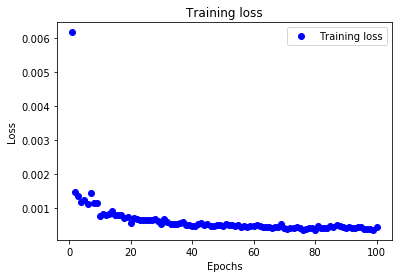

In [26]:
import matplotlib.pyplot as plt

loss = history.history['loss']

epochs = range(1, len(loss) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')

plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


## Testing our LSTM
We have trained our LSTM, now is the time to test the performance of trained model on the test set by predicting the opening stock prices for the month of August 2020. 

As we did with the training data, we need to convert our test data in the right format.
Let's first import our test data. Execute the following:


In [27]:
apple_testing_complete = pd.read_csv(r'AAPL_test.csv')  
apple_testing_processed = apple_testing_complete.iloc[:, 1:2].values  

print("Number of data points in August: ", apple_testing_processed.size)

Number of data points in August:  20


## Converting Test Data to Right Format

For each day of August 2020, we want our feature set to contain the opening stock prices for the previous 60 days. For the 3rd of August, we need the stock prices for the previous 60 days. To do so, we need to concatenate our training data and test data before preprocessing. Execute the following to do so:


In [28]:
apple_total = pd.concat((apple_training_complete['Open'], apple_testing_complete['Open']), axis=0)  

Now let's prepare our test inputs. The input for each day should contain the opening stock prices for the previous 60 days. That means we need opening stock prices for the 20 test days for the month of August 2020 and the 60 stock prices from the last 60 days for the training set. Execute the following code to fetch those 80 values.

In [29]:
test_inputs = apple_total[len(apple_total) - len(apple_testing_complete) - 60:].values  

As we did for the training set, we need to scale the test data. Execute the following:

In [30]:
test_inputs = test_inputs.reshape(-1,1)  
test_inputs = scaler.transform(test_inputs)  


We scaled our data, now let's prepare the final test input set that will contain previous 60 stock prices for the month of January. Execute the following:

In [31]:
test_features = []  
for i in range(60, 80):  
    test_features.append(test_inputs[i-60:i, 0])


Finally, we need to convert our data into the three-dimensional format which can be used as input to the LSTM. Execute the following code

In [32]:
test_features = np.array(test_features)  
test_features = np.reshape(test_features, (test_features.shape[0], test_features.shape[1], 1))  


## Making Predictions
We preprocessed the test data and now we can use them to make predictions. To do so, we simply need to call the `predict()` method on the `model` that we trained. Execute the following


In [34]:
predictions = model.predict(test_features)  

Since we scaled our data, the predictions made by the LSTM are also scaled. We need to reverse the scaled prediction back to their actual values. To do so, we use the `ìnverse_transform` method of the `scaler` object we created during the training. This is accomplished with the following 

In [35]:
predictions = scaler.inverse_transform(predictions)  

Finally, let us see how well did our network predicted the future stock prices. Blue values are actual prices of Apple stock in August 2020. The red values are predictions based on the historic prices, from January 2012 to the end of July 2020. 

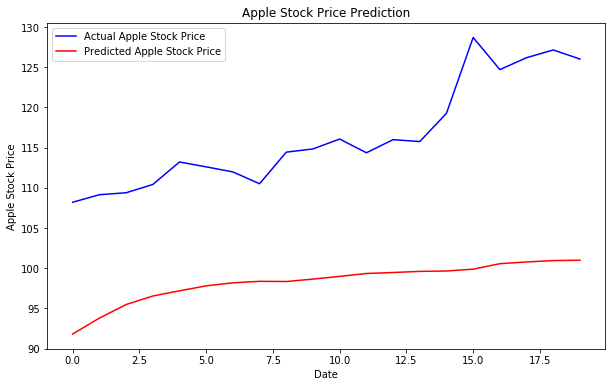

In [36]:
plt.figure(figsize=(10,6))  
plt.plot(apple_testing_processed, color='blue', label='Actual Apple Stock Price')  
plt.plot(predictions , color='red', label='Predicted Apple Stock Price')  
plt.title('Apple Stock Price Prediction')  
plt.xlabel('Date')  
plt.ylabel('Apple Stock Price')  
plt.legend()  
plt.show()  


At least, the trend is correct.